In [1]:
from pathlib import Path
import pandas as pd

# Use repo-relative `pr` directory (Windows)
print("cwd:", Path.cwd())
base_path = Path("pr")
print("resolved:", base_path.resolve())
print("exists:", base_path.exists())

records = []
if base_path.exists():
    for f in sorted(base_path.rglob("*")):
        if not f.is_file():
            continue

        read_ok = True
        detail = "ok"
        n_rows = None
        n_cols = None

        try:
            ext = f.suffix.lower()

            if ext == ".csv":
                df_tmp = pd.read_csv(f)
                n_rows, n_cols = df_tmp.shape
            elif ext in [".tsv", ".txt"]:
                df_tmp = pd.read_csv(f, sep="\t")
                n_rows, n_cols = df_tmp.shape
            elif ext == ".json":
                df_tmp = pd.read_json(f)
                n_rows, n_cols = df_tmp.shape
            elif ext == ".parquet":
                df_tmp = pd.read_parquet(f)
                n_rows, n_cols = df_tmp.shape
            elif ext in [".xlsx", ".xls"]:
                df_tmp = pd.read_excel(f)
                n_rows, n_cols = df_tmp.shape
            else:
                # Validación básica de lectura para otros tipos
                with open(f, "rb") as fh:
                    _ = fh.read(1024)

        except Exception as e:
            read_ok = False
            detail = str(e)

        records.append(
            {
                "file_name": f.name,
                "file_path": str(f),
                "size_bytes": f.stat().st_size,
                "read_ok": read_ok,
                "rows": n_rows,
                "cols": n_cols,
                "detail": detail,
            }
        )
else:
    print(f"No existe la ruta: {base_path}")

ds = pd.DataFrame(records)
display(ds)
print(f"Total de archivos encontrados: {len(ds)}")

cwd: c:\Users\pgome\Documents\GitHub\TESIS
resolved: C:\Users\pgome\Documents\GitHub\TESIS\pr
exists: True


,file_name,file_path,size_bytes,read_ok,rows,cols,detail
0,.DS_Store,pr\.DS_Store,6148,True,None,None,ok
1,CR2MET_pr_v2.5_day_1966_01_005deg.nc,pr\CR2MET_pr_v2.5_day_1966_01_005deg.nc,22010448,True,None,None,ok
2,CR2MET_pr_v2.5_day_1966_02_005deg.nc,pr\CR2MET_pr_v2.5_day_1966_02_005deg.nc,19898424,True,None,None,ok
3,CR2MET_pr_v2.5_day_1966_03_005deg.nc,pr\CR2MET_pr_v2.5_day_1966_03_005deg.nc,22010448,True,None,None,ok
4,CR2MET_pr_v2.5_day_1966_04_005deg.nc,pr\CR2MET_pr_v2.5_day_1966_04_005deg.nc,21306440,True,None,None,ok
...,...,...,...,...,...,...,...
668,CR2MET_pr_v2.5_day_2021_08_005deg.nc,pr\CR2MET_pr_v2.5_day_2021_08_005deg.nc,22010448,True,None,None,ok
669,CR2MET_pr_v2.5_day_2021_09_005deg.nc,pr\CR2MET_pr_v2.5_day_2021_09_005deg.nc,21306440,True,None,None,ok
670,CR2MET_pr_v2.5_day_2021_10_005deg.nc,pr\CR2MET_pr_v2.5_day_2021_10_005deg.nc,22010448,True,None,None,ok
671,CR2MET_pr_v2.5_day_2021_11_005deg.nc,pr\CR2MET_pr_v2.5_day_2021_11_005deg.nc,21306440,True,None,None,ok


Total de archivos encontrados: 673


In [2]:
# Cargar dataset CR2MET desde los archivos en `pr` y definir punto de Stgo centro
import xarray as xr
from pathlib import Path

pr_dir = Path('pr')
files = sorted(pr_dir.glob('CR2MET_pr_v2.5_day_*.nc'))
print('Archivos encontrados:', len(files))
if not files:
    raise RuntimeError('No se encontraron archivos CR2MET en pr/')

# Abrir con xarray (usar dask para eficiencia si está disponible)
ds = xr.open_mfdataset([str(p) for p in files], combine='by_coords', parallel=True, chunks={'time': 365})
print(ds)

# Coordenadas de Santiago centro
lat_sc = -33.45
lon_sc = -70.66
print('lat_sc =', lat_sc, 'lon_sc =', lon_sc)

pr_sc = ds["pr"].sel(lat=lat_sc, lon=lon_sc, method="nearest")

# Intentar seleccionar el punto más cercano usando nombres de coordenadas comunes
lat_name = next((n for n in ds.coords if 'lat' in n.lower()), None)
lon_name = next((n for n in ds.coords if 'lon' in n.lower()), None)
print('lat coord:', lat_name, 'lon coord:', lon_name)
if lat_name and lon_name:
    point = ds.sel({lat_name: lat_sc, lon_name: lon_sc}, method='nearest')
    print('Coordenadas del punto más cercano:', float(point[lat_name]), float(point[lon_name]))
else:
    print('No se encontraron coordenadas lat/lon en el dataset. Coordenadas disponibles:', list(ds.coords))

Archivos encontrados: 672


C:\Users\pgome\AppData\Local\Temp\ipykernel_12396\412657175.py:12: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  ds = xr.open_mfdataset([str(p) for p in files], combine='by_coords', parallel=True, chunks={'time': 365})


<xarray.Dataset> Size: 72GB
Dimensions:  (time: 20454, lat: 800, lon: 220)
Coordinates:
  * time     (time) datetime64[ns] 164kB 1966-01-01 1966-01-02 ... 2021-12-31
  * lat      (lat) float64 6kB -56.98 -56.93 -56.88 ... -17.12 -17.07 -17.02
  * lon      (lon) float64 2kB -76.97 -76.92 -76.88 ... -66.12 -66.08 -66.03
Data variables:
    pr       (time, lat, lon) float64 29GB dask.array<chunksize=(31, 800, 220), meta=np.ndarray>
    pr_sd    (time, lat, lon) float64 29GB dask.array<chunksize=(31, 800, 220), meta=np.ndarray>
    cl_mask  (time, lat, lon) float32 14GB dask.array<chunksize=(31, 800, 220), meta=np.ndarray>
Attributes: (12/28)
    creation_date:        29-Aug-2022 18:44:17
    authors:              Boisier et al.
    obs_file:             MERGE5_QC_UCC_pr_day_1979_2021.csv
    topo_res:             005 025 05
    ls_vars_all:          pr logpr prc prmax pr2d iqu iqv tcw cape
    ls_vars_o15:          iqu iqv tcw cape
    ...                   ...
    ens_qtl_value:        0

In [3]:
pr_sc = pr_sc.sel(time=slice("1979-01-01", "2021-12-31"))
print("Días en el período:", pr_sc.time.size)

Días en el período: 15706


In [4]:
dry_day = (pr_sc < 1.0)

### Extraer dry spells (rachas True consecutivas) y filtrar ≥ 3 días

In [5]:
import numpy as np
import pandas as pd

def dry_spells_from_bool(time_index, dry_bool, min_len=3):
    dry = np.asarray(dry_bool, dtype=bool)

    x = np.r_[False, dry, False]
    dx = np.diff(x.astype(int))

    starts = np.where(dx == 1)[0]
    ends_excl = np.where(dx == -1)[0]
    lengths = ends_excl - starts

    mask = lengths >= min_len
    starts = starts[mask]
    ends_excl = ends_excl[mask]
    lengths = lengths[mask]

    t = np.asarray(time_index)
    start_dates = t[starts]
    end_dates = t[ends_excl - 1]

    df = pd.DataFrame({
        "start": pd.to_datetime(start_dates),
        "end": pd.to_datetime(end_dates),
        "duration_days": lengths.astype(int)
    }).sort_values("start").reset_index(drop=True)

    return df

df_spells = dry_spells_from_bool(
    time_index=pr_sc["time"].values,
    dry_bool=dry_day.values,
    min_len=3
)

df_spells.head(10)


,start,end,duration_days
0,1979-01-01,1979-01-10,10
1,1979-01-12,1979-02-07,27
2,1979-02-09,1979-04-03,54
3,1979-04-05,1979-04-26,22
4,1979-04-28,1979-05-01,4
5,1979-05-03,1979-05-15,13
6,1979-05-17,1979-06-21,36
7,1979-06-23,1979-07-24,32
8,1979-08-04,1979-08-23,20
9,1979-09-01,1979-09-06,6


Un día seco fue definido como aquel con precipitación diaria menor a 1 mm. Los dry spells se identificaron como secuencias de días secos consecutivos, considerando únicamente aquellos eventos con una duración mínima de tres días. La duración de cada dry spell se calculó como el número total de días consecutivos secos que componen cada evento.

### Calculamos la duración de todos los dry spells

In [6]:
duraciones = df_spells["duration_days"].to_numpy()
print("Cantidad de dry spells (>=3 días):", len(duraciones))
print("Primeras 20 duraciones:", duraciones[:20])


Cantidad de dry spells (>=3 días): 740
Primeras 20 duraciones: [10 27 54 22  4 13 36 32 20  6  3  8 38  4  3 16  6 57 10 47]


### Tomaremos el primer evento y veremos 

In [7]:
df_spells.iloc[0]


start            1979-01-01 00:00:00
end              1979-01-10 00:00:00
duration_days                     10
Name: 0, dtype: object

--- Tendencias en Santiago (Días/Década) ---
mean_dur:   0.64 días/década
max_dur :   7.61 días/década
p99_dur :   9.21 días/década
tL      :   2.32 días/década


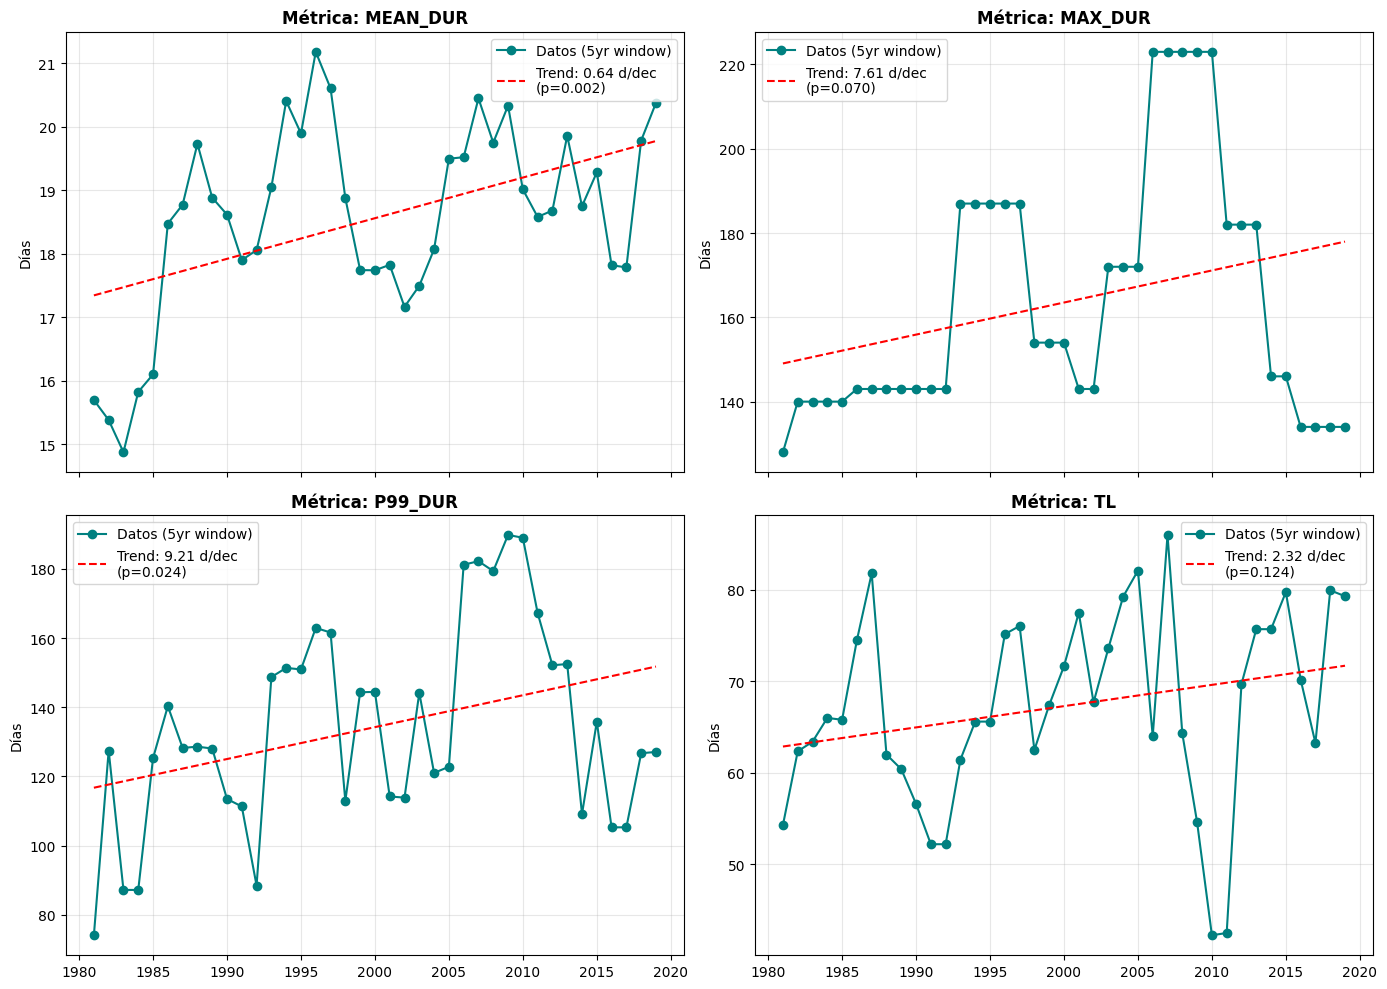

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats # Para la tendencia lineal

# 1. Preparación de los datos (Igual que antes)
df = df_spells.copy()
df["start"] = pd.to_datetime(df["start"])
df["year"] = df["start"].dt.year

# 2. Nueva lógica: Ventanas de 5 años (Agregamos primero la data)
# Definimos el inicio de cada ventana. Terminamos en 2017 para que la última sea 2017-2021.
years_start = np.arange(1979, 2018) 
results_5yr = []

for start_y in years_start:
    end_y = start_y + 4
    
    # FILTRO: Seleccionamos todos los eventos que caen en este bloque de 5 años
    mask = (df["year"] >= start_y) & (df["year"] <= end_y)
    window_data = df.loc[mask, "duration_days"]
    
    if not window_data.empty:
        # CÁLCULO: Estadísticas sobre el conjunto total del bloque
        results_5yr.append({
            "year_center": start_y + 2, # Año central para el eje X
            "mean_dur": window_data.mean(),
            "max_dur": window_data.max(),
            "p99_dur": np.percentile(window_data, 99),
            "tL": np.percentile(window_data, 95) # Escala de corte tL
        })

# Creamos el DataFrame con las estadísticas de 5 años (reemplaza a tu 'rm')
rm = pd.DataFrame(results_5yr).set_index("year_center")

# 3. Cálculo de Tendencias y Gráficos (Lo que falta de la pregunta)
metrics = ["mean_dur", "max_dur", "p99_dur", "tL"]
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
axes = axes.flatten()

print("--- Tendencias en Santiago (Días/Década) ---")
for i, m in enumerate(metrics):
    y = rm[m].values
    x = rm.index.values
    
    # Regresión lineal
    slope, intercept, r_val, p_val, std_err = stats.linregress(x, y)
    trend_decade = slope * 10 # Convertir a días por década
    
    # Graficar
    axes[i].plot(rm.index, y, 'o-', label='Datos (5yr window)', color='teal')
    axes[i].plot(x, intercept + slope*x, 'r--', 
                 label=f'Trend: {trend_decade:.2f} d/dec\n(p={p_val:.3f})')
    
    axes[i].set_title(f"Métrica: {m.upper()}", fontweight='bold')
    axes[i].set_ylabel("Días")
    axes[i].legend()
    axes[i].grid(alpha=0.3)
    
    print(f"{m:8}: {trend_decade:6.2f} días/década")

plt.tight_layout()
plt.show()

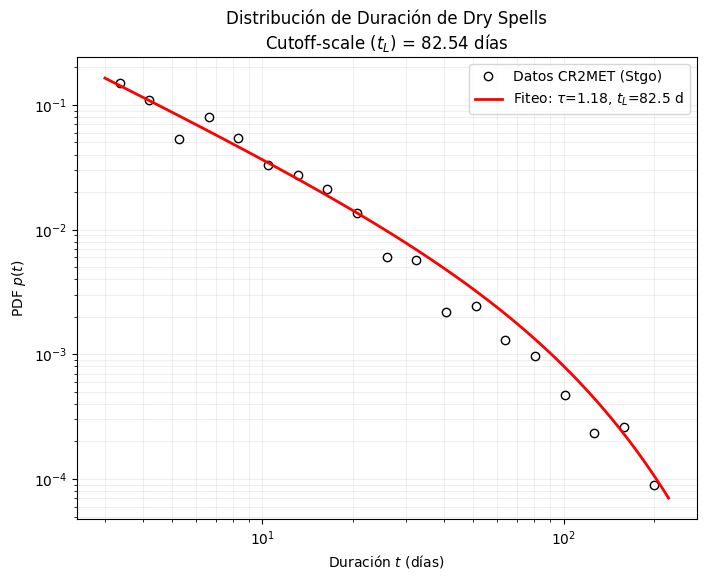

Resultado del Fiteo:
Tau (Ley de potencia): 1.1817
tL (Escala de corte): 82.5408 días


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# 1. Preparar las duraciones (sin mínimo, como pidió el profe)
data = df_spells["duration_days"].values
data = data[data > 0] # Asegurar que no hay ceros para el logaritmo

# 2. Binning Logarítmico
# Creamos bins que se duplican en tamaño
bins = np.logspace(np.log10(min(data)), np.log10(max(data)), 20)
counts, bin_edges = np.histogram(data, bins=bins, density=True)
bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:]) # Centro geométrico para log-scale

# 3. Función funcional para el fiteo
def power_law_cutoff(t, A, tau, tL):
    return A * (t**-tau) * np.exp(-t/tL)

# 4. Fiteo (Ajuste)
# Usamos valores iniciales (p0) basados en la literatura: tau ~ 1.5
popt, pcov = curve_fit(power_law_cutoff, bin_centers, counts, p0=[1, 1.5, 50])
A_fit, tau_fit, tL_fit = popt

# 5. Gráfico
plt.figure(figsize=(8, 6))
plt.loglog(bin_centers, counts, 'ko', label='Datos CR2MET (Stgo)', mfc='none')
t_range = np.logspace(np.log10(min(data)), np.log10(max(data)), 100)
plt.plot(t_range, power_law_cutoff(t_range, *popt), 'r-', lw=2, 
         label=f'Fiteo: $\\tau$={tau_fit:.2f}, $t_L$={tL_fit:.1f} d')

plt.title(f"Distribución de Duración de Dry Spells\nCutoff-scale ($t_L$) = {tL_fit:.2f} días", fontsize=12)
plt.xlabel("Duración $t$ (días)")
plt.ylabel("PDF $p(t)$")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

print(f"Resultado del Fiteo:")
print(f"Tau (Ley de potencia): {tau_fit:.4f}")
print(f"tL (Escala de corte): {tL_fit:.4f} días")

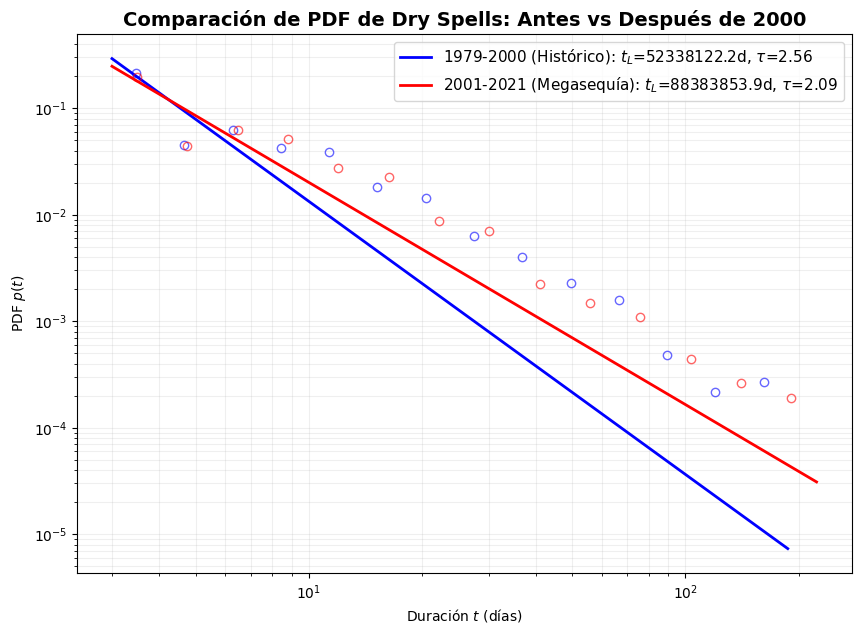

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# 1. Asegurar que existan las columnas necesarias
df = df_spells.copy()
if "year" not in df.columns:
    df["year"] = pd.to_datetime(df["start"]).dt.year

# 2. Identificar el nombre de la columna de duración
# (Revisamos si es 'duration' o 'duration_days')
col_dur = "duration" if "duration" in df.columns else "duration_days"

# 3. Definir los dos periodos
df_p1 = df[df["year"] <= 2000][col_dur].values
df_p2 = df[df["year"] > 2000][col_dur].values

periodos = [
    {"data": df_p1[df_p1 > 0], "label": "1979-2000 (Histórico)", "color": "blue"},
    {"data": df_p2[df_p2 > 0], "label": "2001-2021 (Megasequía)", "color": "red"}
]

def power_law_cutoff(t, A, tau, tL):
    return A * (t**-tau) * np.exp(-t/tL)

plt.figure(figsize=(10, 7))

for p in periodos:
    # Binning logarítmico
    bins = np.logspace(np.log10(min(p["data"])), np.log10(max(p["data"])), 15)
    counts, bin_edges = np.histogram(p["data"], bins=bins, density=True)
    bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])
    
    # Ajuste (Fit)
    try:
        popt, _ = curve_fit(power_law_cutoff, bin_centers, counts, p0=[1, 1.2, 50])
        A_f, tau_f, tL_f = popt
        
        # Graficar
        plt.loglog(bin_centers, counts, 'o', color=p["color"], mfc='none', alpha=0.6)
        t_range = np.logspace(np.log10(min(p["data"])), np.log10(max(p["data"])), 100)
        plt.plot(t_range, power_law_cutoff(t_range, *popt), color=p["color"], lw=2,
                 label=f"{p['label']}: $t_L$={tL_f:.1f}d, $\\tau$={tau_f:.2f}")
    except Exception as e:
        print(f"No se pudo ajustar el periodo {p['label']}: {e}")

plt.title("Comparación de PDF de Dry Spells: Antes vs Después de 2000", fontsize=14, fontweight='bold')
plt.xlabel("Duración $t$ (días)")
plt.ylabel("PDF $p(t)$")
plt.legend(fontsize=11)
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()